<a href="https://colab.research.google.com/github/claudiosegala/Monografia/blob/master/code/tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

Connect to Google Drive of 'alfredcoinworth'

In [1]:
import google as g # To connect with google drive
g.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Retrieve and Instanciate Dependencies


For this work, we will need these libraries

In [2]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install keras
!pip install statsmodels

In [3]:
import tensorflow as tf # machine learning library
import pandas as pd # data manipulation library
import matplotlib.pyplot as plt # plot library
import numpy as np # math library
import datetime as dt # to discover week day
import time as tm # to convert to seconds
import sklearn as skl # regression templates library
import sklearn.metrics as sklm # metrics
import statsmodels.api as sma # statistical models api
import statistics as st # statistics
import statsmodels as sm # statistical models

import math
import json
import copy

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


# Configurations


In [0]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [0]:
# Machine Config Parameters
TCC_PATH = '/content/drive/My Drive/TCC/' # ''

# General Util

In [0]:
def flatten (m):
  """ Flatten
  
  Transform a matrix in an array.
  
  Arguments:
    m: the matrix to be flatten
  """
  
  return [i for sl in m for i in sl]

# Dataset Retrieval Util

This phase we have to get the data stored in Google Drive and transform into a dataset for prediction.


In [0]:
def retrieve_data(verbosity):
  path = f"{TCC_PATH}dataset/all_data_sorted.csv"
  
  col_names = [
    'Sensor',
    'Date',
    'Time',
    'Lane',
    'Speed',
    'Max Speed',
    'Size'
  ]
  
  data = pd.read_csv(path, ';', header=None, names=col_names)
  
  if verbosity:
    data.head()
    # data.describe()
  
  return data

In [0]:
def clean_data(data, verbosity):
  # Extract data from just one sensor
  data = data[data['Sensor'] == 'RSI128']
  
  # Remove unnecessary columns
  data = data.drop(columns=['Sensor','Lane','Max Speed','Size'])
  
  data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
   
  # Adjust type
  f = lambda x : tm.strptime(x, '%H:%M:%S')
  data['Time'] = data['Time'].apply(f)
  
  g = lambda x : dt.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
  data['Time'] = data['Time'].apply(g)
  
  h = lambda x : int(x)
  data['Time'] = data['Time'].apply(h)
  
  i = lambda x : float(x)
  data['Speed'].apply(i)
  
  # Create week day from date
  j = lambda x : x.weekday()
  data['WeekDay'] = data['Date'].apply(j)
  
  if verbosity:
    for col, cont in data.iteritems():
        print(f"Column {col} has {cont.isnull().sum()} null elements")
        print(f"Column {col} has {cont.isna().sum()} nan elements")
        
    print()
        
    start = data['Date'].min()
    end = data['Date'].max()
    print(f"This data is from <{start}> to <{end}>. {end - start} days.\n")

    print(f"It contains {len(data['Date'])} entries\n")

        
    data.head()
    # data.describe()
  
  return data

# Flow Generation Util

The plot is based on [A Guide to Time Series Visualization with Python 3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3).


In [0]:
def get_flow_data(n, accSpeed, weekDay):
  avgSpeed = (accSpeed // n) if n else 0
  density = (n / avgSpeed) if avgSpeed else 0
  w = [(1 if weekDay == i else 0) for i in range(7)] # weekday
  
  return (n, density, avgSpeed, w[0], w[1], w[2], w[3], w[4], w[5], w[6])

In [0]:
def plot_flow(flow_series, freq):
  decompose = sm.tsa.seasonal.seasonal_decompose
  decomposition = decompose(flow_series, model='additive', freq=freq)
  fig = decomposition.plot()

  plt.rcdefaults()
  plt.plot()

In [0]:
def get_flow (data, flow_interval, verbosity):
  date = np.asarray(data['Date'])
  weekDay = np.asarray(data['WeekDay'])
  time = np.asarray(data['Time'])
  speed = np.asarray(data['Speed'])
  
  dateControl = date[0]
  timeBlock = flow_interval
  countFlow = 0
  accSpeed = 0
  flowData = []

  for i in range(len(date)):
    if time[i] >= timeBlock: # init a new time block
      flowData.append(get_flow_data(countFlow, accSpeed, weekDay[i])) 
      timeBlock += flow_interval
      accSpeed = 0
      countFlow = 0
      
    if date[i] > dateControl: # reset on day change
      dateControl = date[i]
      timeBlock = flow_interval 
      countFlow = 0
      accSpeed = 0
      
    if time[i] < timeBlock: # add car on flow
      countFlow += 1
      accSpeed += speed[i]
      
  flowDataColumns = [
    'Flow',
    'Density',
    'AveSpeed',
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
  ]
  
  flowData = pd.DataFrame(flowData, columns=flowDataColumns) 
  
  if verbosity:
    plot_flow(flowData['Flow'], WEEK_SIZE)

    flowData.describe()
  
  return flowData

# Dataset Generation Util

In [0]:
# 
def split_sequence(sequence, isMulti, n_steps, n_future):
  """ Split Sequence
  
  Split a sequence in rolling intervals with a corresponding value 
  like the example bellow.
  
  Ex: split_sequence([1, 2, 3, 4, 5], 3) #([[1, 2, 3], [2, 3, 4]], [4, 5])
  
  Arguments:
    sequence: the sequence to split.
    isMulti: if the data is multivariate or not.
    n_steps: size of the rolling interval
    n_future: the distance to the interval the value should be.  
  """
  
  n = len(sequence)
  X, Y = list(), list()
  
  for i in range(n):
    j = i + n_steps
    k = j + n_future

    if k >= n:
      break

    seq_x, seq_y = sequence[i:j], sequence[k]
    X.append(seq_x)
    Y.append(seq_y[0] if isMulti else seq_y)

  return np.array(X), np.array(Y)

In [0]:
def reshape_flow (raw_seq, isMulti, n_steps, n_future, verbosity): 
  """ Reshape Flow
  
  Reshape a sequence in rolling intervals from [samples, timesteps] into 
  [samples, timesteps, features].
  
  Arguments:
    raw_seq: the sequence to reshape.
    isMulti: if the data is multivariate or not.
    n_steps: size of the rolling interval
    n_future: the distance to the interval the value should be.  
  """
  
  X, Y = split_sequence(np.array(raw_seq), isMulti, n_steps, n_future)
  
  
  if not isMulti:
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
  if verbosity:
    print(f"X Shape: {X.shape}")
    print(f"Y Shape: {Y.shape}")

  return X, Y

# Models Util

## Misc

Function to help implement the training and evaluation of the models.


In [0]:
def plot_history (history, name):
  """ Plot of History
  
  Plot the history of loss in the training session of a model
  
  Arguments:
    history: the history returned by Keras fit of a model
    name: the name of the model
  """
  
  path = f"{TCC_PATH}plots/histories/{name}"
  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.rcdefaults()
  
  plt.savefig(path + ".png", bbox_inches='tight')
  plt.savefig(path + ".pdf")
  
  #plt.show(name + "ind")
  plt.close('all')

In [0]:
def plot_prediction (Y, Y_hat, title):
  """ Plot Prediction
  
  Plot the prediction (Flow x Time) of what was expected and what
  was predicted.
  
  """
  
  n = math.floor(len(Y) / DAY_SIZE)
  Y = flatten(Y)
  Y_hat = flatten(Y_hat)
  
  for r in range(n):
    i = r * DAY_SIZE
    j = min(i + DAY_SIZE, len(Y))
    
    name = f"{title} ({str(r+1).zfill(2)} of {n})"
    path = f"{TCC_PATH}plots/predictions/{name}"
    
    plt.plot(Y[i:j])
    plt.plot(Y_hat[i:j])
    plt.title(title + 'Prediction')
    plt.ylabel('Flow')
    plt.xlabel('Time')
    plt.legend(['actual', 'prediction'], loc='upper left')
    plt.rcdefaults()

    plt.savefig(path + ".png", bbox_inches='tight')
    plt.savefig(path + ".pdf")

    plt.close('all')

In [0]:
def split_dataset (n, window_split, test_split):
  """ Dataset Split
  
  Generate pointers for the training and test of the models based
  on the splits.
  
  Arguments:
    n: size of the dataset.
    window_split: percentage of the dataset that will be used in each 
      train&test sample.
    test_split: percentage of the train&test sample that will be 
      dedicated to testing.
  """
  
  sz_window = int(n * window_split)
  sz_test = int(sz_window * test_split)
  sz_train = sz_window - sz_test
  sz_jump = sz_test

  i, j, k = 0, sz_train, min(n, sz_train + sz_test)
  
  res = []
  
  while j < n:
    res.append((i, j, k))
    
    i = i + sz_jump
    j = i + sz_train
    k = min(n, j + sz_test)
    
  return res

In [0]:
def evaluate_precision_hit_ratio (Y, Y_hat):
  """ Trend Prediction Ratio Calculation
  
  Calculates the ratio of up/down prediction.
  
  Arguments:
    Y: the expected dataset.
    Y_hat: the observed dataset.
  """
  
  cnt = 0
  
  for i in range(len(Y)):
    if i < N_FUTURE:
      continue
      
    exp = Y[i] - Y[i - N_FUTURE]
    obs = Y_hat[i] - Y[i - N_FUTURE]
    
    if exp * obs > 0:
      cnt += 1
    
  return cnt / len(Y)

In [0]:
def evaluate_precision_bucket (Y, Y_hat):
  """ Precision Bucket Calculation
  
  Counts how many of the prediction got wronng by at most 2ˆx, x 
  being the bucket. There are 7 buckets, that is, the maximum error 
  calculated is 128.
  
  Arguments:
    Y: the expected dataset.
    Y_hat: the observed dataset.
  """
  
  n = 7 # the number of buckets
  buckets = [0] * n
  
  for i in range(len(Y)):
    diff = abs(Y[i] - Y_hat[i])
    
    for i in range (n):
      if diff <= 2**i:
        buckets[i] += 1
        break

  for i in range (n):
     buckets[i] = buckets[i] / len(Y)

  return tuple(buckets)

In [0]:
def evaluate_raw (expected, observed, times):
  """ Evaluate Raw Sessions 
  
  Evaluate each of the train&test sessions by RMSE, NRMSE, MAE, HR, PRE. 
  It will store the results in a object and return it.
  
  Arguments:
    expected: an array of expected instances of each train&test session.
    observed: an array of observed instances of each train&test session.
    times: an array of the time of each train&test session.
  """
  
  n = len(expected)
  
  raw = {
    'expected': expected,
    'observed': observed,
    'TIME': times,
    'RMSE': [0] * n,
    'NRMSE': [0] * n,
    'MAE': [0] * n,
    'HR': [0] * n,
    'PRE': [0] * n,
  }
  
  for i in range(n):
    Y = expected[i]
    Y_hat = observed[i]
    time = times[i]

    raw['MAE'][i] = sklm.mean_absolute_error(Y, Y_hat)
    raw['RMSE'][i] = np.sqrt(sklm.mean_squared_error(Y, Y_hat))
    raw['NRMSE'][i] = raw['RMSE'][i] / np.std(Y)
    raw['HR'][i] = evaluate_precision_hit_ratio(Y, Y_hat)
    raw['PRE'][i] = evaluate_precision_bucket(Y, Y_hat)
    
    if VERBOSITY:
      print(f"({i+1}/{n}) Test Size: {len(Y)}, Time: {time}s")
      print(f"\tRMSE: {raw['RMSE'][i]}")
      print(f"\tNRMSE: {raw['NRMSE'][i]}")
      print(f"\tMAE: {raw['MAE'][i]}")
      print(f"\tHit Ratio: {raw['HR'][i] * 100}%")

  return raw

In [0]:
def evaluate (expected, observed, times, desnormalize):
  """ Evaluate Sessions
  
  Evaluate models by RMSE, NRMSE, MAE, HR, PRE. It will store the 
  results in a object and return it.
  
  Arguments:
    expected: an array of expected instances of each 
      train&test session.
    observed: an array of observed instances of each 
      train&test session.
    times: an array of the time of each train&test session.
    desnormalize: if it should desnormalize the results
  """
  n = len(expected)
  
  # Make the arrays serializable
  expected = list(map(list, expected))
  observed = list(map(list, observed))
  
  for i in range(n):
    expected[i] = list(map(float, expected[i]))
    observed[i] = list(map(float, observed[i]))

  if desnormalize:
    for i in range(n):
      expected[i] = list(scaler.inverse_transform(expected[i]))
      observed[i] = list(scaler.inverse_transform(observed[i]))
  
  raw = evaluate_raw(expected, observed, times)
  
  n_buckets = len(raw['PRE'])
  _pre = [[pre[i] for pre in raw['PRE']] for i in range(n_buckets)]
  
  eva = {
    'TIME': int(sum(times)),
    'RMSE': float(np.mean(raw['RMSE'])),
    'NRMSE': float(np.mean(raw['NRMSE'])),
    'MAE': float(np.mean(raw['MAE'])),
    'HR': float(np.mean(raw['HR'])),
    'PRE': [float(np.mean(p)) for p in _pre],
    'has_negative': (min(flatten(observed)) < 0),
    'raw': raw
  }
  
  if VERBOSITY:
    print(f"FINAL RESULT:")
    print(f"\tTotal Time: {eva['TIME']}s")
    print(f"\tRMSE: {eva['RMSE']}")
    print(f"\tNRMSE: {eva['NRMSE']}")
    print(f"\tMAE: {eva['MAE']}")
    print(f"\tHit Ratio: {eva['HR'] * 100}%")
    print(f"\tPrecision: {eva['PRE']}")
    
  return eva

## Random (Baseline)

This implementation just guess a random number in the [0, 100] interval for every output.

In [0]:
import random as rnd # random

In [0]:
def random_guess_univariate (Y):
  global result_data

  name = "Random Guess"
  m = max(Y)

  expected, observed, times = [], [], []
  pointers = split_dataset(len(Y), SET_SPLIT, TEST_SPLIT)
  
  for i, j, k in pointers:
    start = tm.time()

    Y_hat = [rnd.randint(0, m) for i in range(k - j)]

    expected.append(Y[j:k])
    observed.append(Y_hat)
    times.append(tm.time() - start)

  result_data['results'][name] = evaluate(expected, observed, times, NORMALIZE_FEATS)

  if VERBOSITY:
    plot_prediction(expected, observed, name)

## Moving Average (Baseline)

This implementation just get the mean of every flow value in the input and place it as output.

In [0]:
def moving_average (X, Y):
  global result_data
  
  name = "Moving Average"
  expected, observed, times = [], [], []
  pointers = split_dataset(len(X), SET_SPLIT, TEST_SPLIT)
  
  X = X.reshape(X.shape[0], X.shape[1])
  
  for i, j, k in pointers:
    start = tm.time()
    
    Y_hat = [np.mean(x) for x in X[j:k]]
    
    expected.append(Y[j:k])
    observed.append(Y_hat)
    times.append(tm.time() - start)
    
  result_data['results'][name] = evaluate(expected, observed, times, NORMALIZE_FEATS)
  
  if VERBOSITY:
    plot_prediction(expected, observed, name)

## Naive (Baseline)

This implementation just use the last value of input as output.

In [0]:
def naive (X, Y):
  global result_data
  
  name = "Naive"
  expected, observed, times = [], [], []
  pointers = split_dataset(len(X), SET_SPLIT, TEST_SPLIT)
  
  X = X.reshape(X.shape[0], X.shape[1])
  
  for i, j, k in pointers:
    start = tm.time()
    
    Y_hat = [x[-1] for x in X[j:k]]
    
    expected.append(Y[j:k])
    observed.append(Y_hat)
    times.append(tm.time() - start)
    
  result_data['results'][name] = evaluate(expected, observed, times, NORMALIZE_FEATS)
  
  if VERBOSITY:
    plot_prediction(expected, observed, name)

## Random Forest

This implementation is based on [Random Forest Algorithm with Python and Scikit-Learn](https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/)

In [0]:
from sklearn.ensemble.forest import RandomForestRegressor

In [0]:
def random_forest(X, Y, isMulti):
  global result_data
  
  name = "RF Multivariate" if isMulti else "RF Univariate"
  
  model = skl.ensemble.RandomForestRegressor(n_estimators=100, max_features='auto', random_state=0)

  expected, observed, times = [], [], []
  pointers = split_dataset(len(X), SET_SPLIT, TEST_SPLIT)
  
  X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
  
  for i, j, k in pointers:
    start = tm.time()
    
    model.fit(X[i:j], Y[i:j])
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
  result_data['results'][name] = evaluate(expected, observed, times, NORMALIZE_FEATS)
  
  if VERBOSITY:
    plot_prediction(expected, observed, name)

## Support Vector Machine

In [0]:
from sklearn import svm

In [0]:
def support_vector_machine(X, Y, isMulti):
  global result_data
  
  name = "SVM Multivariate" if isMulti else "SVM Univariate"
  
  model = svm.SVR(gamma='scale', C=1.0, epsilon=0.2)

  expected, observed, times = [], [], []
  pointers = split_dataset(len(X), SET_SPLIT, TEST_SPLIT)
  
  X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
  
  for i, j, k in pointers:
    start = tm.time()
    
    model.fit(X[i:j], Y[i:j])
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
  result_data['results'][name] = evaluate(expected, observed, times, NORMALIZE_FEATS)
  
  if VERBOSITY:
    plot_prediction(expected, observed, name)

## RNN

In [0]:
from keras.layers import SimpleRNN

In [0]:
def rnn (X, Y, isMulti): 
  global result_data
  
  name = "RNN Multivariate" if isMulti else "RNN Univariate"
  
  model = Sequential()
  
  model.add(SimpleRNN(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1, activation='sigmoid' if NORMALIZE_FEATS else 'relu'))
  
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  expected, observed, times = [], [], []
  pointers = split_dataset(len(X), SET_SPLIT, TEST_SPLIT)
  
  for i, j, k in pointers:
    start = tm.time()
    
    hist = model.fit(X[i:j], Y[i:j], validation_split=0.2, batch_size=64, epochs=15, verbose=0)
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
    if VERBOSITY:
      plot_history(hist, f"{name} ({str(len(times)).zfill(2)} of {len(pointers)})")
    
  result_data['results'][name] = evaluate(expected, observed, times, NORMALIZE_FEATS)
  
  if VERBOSITY:
    plot_prediction(expected, observed, name)

## LSTM

In [0]:
from keras.layers import LSTM

In [0]:
def lstm (X, Y, isMulti): 
  global result_data
  
  name = "LSTM Multivariate" if isMulti else "LSTM Univariate"
  
  model = Sequential()
  
  model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1, activation='sigmoid' if NORMALIZE_FEATS else 'relu'))
  
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  expected, observed, times = [], [], []
  pointers = split_dataset(len(X), SET_SPLIT, TEST_SPLIT)
  
  for i, j, k in pointers:
    start = tm.time()
    
    hist = model.fit(X[i:j], Y[i:j], validation_split=0.2, batch_size=64, epochs=15, verbose=0)
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
    if VERBOSITY:
      plot_history(hist, f"{name} ({str(len(times)).zfill(2)} of {len(pointers)})")
    
  result_data['results'][name] = evaluate(expected, observed, times, NORMALIZE_FEATS)
  
  if VERBOSITY:
    plot_prediction(expected, observed, name)

## GRU

In [0]:
from keras.layers import GRU

In [0]:
def gru (X, Y, isMulti): 
  global result_data
  
  name = "GRU Multivariate" if isMulti else "GRU Univariate"
  
  model = Sequential()
  
  model.add(GRU(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(1, activation='sigmoid' if NORMALIZE_FEATS else 'relu'))
  
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])

  expected, observed, times = [], [], []
  pointers = split_dataset(len(X), SET_SPLIT, TEST_SPLIT)
  
  for i, j, k in pointers:
    start = tm.time()
    
    hist = model.fit(X[i:j], Y[i:j], validation_split=0.2, batch_size=64, epochs=15, verbose=0)
    
    expected.append(Y[j:k])
    observed.append(model.predict(X[j:k]))
    times.append(tm.time() - start)
    
    if VERBOSITY:
      plot_history(hist, f"{name} ({str(len(times)).zfill(2)} of {len(pointers)})")
    
  result_data['results'][name] = evaluate(expected, observed, times, NORMALIZE_FEATS)
  
  if VERBOSITY:
    plot_prediction(expected, observed, name)

# Storage Util

In [0]:
def print_json ():
  print(json.dumps(result_data, sort_keys=True, indent=4))

In [0]:
def store_results ():
  name = int(tm.time())
  
  result_data['meta'] = {
    "SEEABLE_PAST": SEEABLE_PAST,
    "PREDICT_IN_FUTURE": PREDICT_IN_FUTURE,
    "FLOW_INTERVAL": FLOW_INTERVAL,
    "NORMALIZE_FEATS": NORMALIZE_FEATS,
    "SET_SPLIT": SET_SPLIT,
    "TEST_SPLIT": TEST_SPLIT,
    "VALIDATION_SPLIT": VALIDATION_SPLIT,
  }
  
  with open(f"{TCC_PATH}results/{name}.json", 'w') as json_file:
    json.dump(result_data, json_file)
    
  slim_result_data = copy.deepcopy(result_data)
  for model in slim_result_data['results']:
      del slim_result_data['results'][model]['raw']
    
  with open(f"{TCC_PATH}results/{name}_slim.json", 'w') as json_file:
    json.dump(slim_result_data, json_file)

In [0]:
def store_comparisons ():
  name = int(tm.time())
  
  with open(f"{TCC_PATH}results/comparison/{name}.json", 'w') as json_file:
    json.dump(comparison_data, json_file)
    
  slim_comparison_data = copy.deepcopy(comparison_data)
  for i in range(len(slim_comparison_data)):
    print([*slim_comparison_data[i]['results']])
    for model in slim_comparison_data[i]['results']:
      del slim_comparison_data[i]['results'][model]['raw']
    
    
  with open(f"{TCC_PATH}results/comparison/{name}_slim.json", 'w') as json_file:
    json.dump(slim_comparison_data, json_file)

# Train&Test

Run all the models and store the results at the end

In [0]:
# Model Parameters

SEEABLE_PAST = 180 # in minutes

PREDICT_IN_FUTURE = 60 # in minutes

FLOW_INTERVAL = 360 # the interval size for each flow

NORMALIZE_FEATS = False #Decide if we gonna use normalized flow and speed values, or not

SET_SPLIT = 0.65

TEST_SPLIT = 0.2

VALIDATION_SPLIT = 0.2

VERBOSITY = True

In [0]:
# Derivated Model Parameters

N_STEPS = SEEABLE_PAST * 60 // FLOW_INTERVAL # the number of flows to see in the past

N_FUTURE = PREDICT_IN_FUTURE * 60 // FLOW_INTERVAL # how much in the future we want to predict (0 = predict the flow on the next 5 minutes)

DAY_SIZE = (24 * 3600) // FLOW_INTERVAL  

WEEK_SIZE = 7 * DAY_SIZE

In [0]:
result_data = {
    'results': {},
    'meta': {}
}

In [0]:
comparison_data = []

In [0]:
all_data = retrieve_data(VERBOSITY)

In [47]:
data = clean_data(all_data, VERBOSITY)

Column Date has 0 null elements
Column Date has 0 nan elements
Column Time has 0 null elements
Column Time has 0 nan elements
Column Speed has 0 null elements
Column Speed has 0 nan elements
Column WeekDay has 0 null elements
Column WeekDay has 0 nan elements

This data is from <2016-05-01 00:00:00> to <2016-07-31 00:00:00>. 91 days 00:00:00 days.

It contains 536879 entries



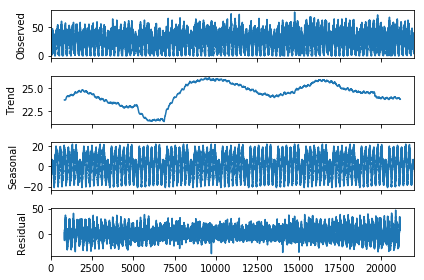

In [48]:
multivariateData = get_flow(data, FLOW_INTERVAL, VERBOSITY)
univariateData = multivariateData['Flow']

In [0]:
if NORMALIZE_FEATS:
  lenth = len(univariateData)
  univariateData = np.asarray(univariateData).reshape((-1, 1))
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(univariateData)
  normalizedData = scaler.transform(univariateData)
  univariateData = np.asarray(normalizedData).reshape(lenth,)
  univariateData = pd.DataFrame(univariateData)

In [50]:
X_uni, Y_uni= reshape_flow(univariateData, False, N_STEPS, N_FUTURE, VERBOSITY)

X Shape: (21948, 30, 1)
Y Shape: (21948,)


In [51]:
X_multi, Y_multi= reshape_flow(multivariateData, True, N_STEPS, N_FUTURE, VERBOSITY)

X Shape: (21948, 30, 10)
Y Shape: (21948,)


In [52]:
random_guess_univariate(Y_uni)

(1/4) Test Size: 2853, Time: 0.00830388069152832s
	RMSE: 31.272150929612412
	NRMSE: 1.9203932393354854
	MAE: 25.596915527514895
	Hit Ratio: 47.143357868909916%
(2/4) Test Size: 2853, Time: 0.00468134880065918s
	RMSE: 31.120037150246745
	NRMSE: 1.796051670487829
	MAE: 25.52365930599369
	Hit Ratio: 47.59901857693656%
(3/4) Test Size: 2853, Time: 0.004796028137207031s
	RMSE: 31.234451442077333
	NRMSE: 1.8222418820543214
	MAE: 25.52926743778479
	Hit Ratio: 47.423764458464774%
(4/4) Test Size: 1976, Time: 0.003127574920654297s
	RMSE: 30.749699646339327
	NRMSE: 1.9086259849929204
	MAE: 25.11589068825911
	Hit Ratio: 45.90080971659919%
FINAL RESULT:
	Total Time: 0s
	RMSE: 31.09408479206895
	NRMSE: 1.861828194217639
	MAE: 25.441433239888124
	Hit Ratio: 47.016737655227615%
	Precision: [0.03481259871347867, 0.025564485001227488, 0.0444427060938766, 0.09250472902307535]


In [53]:
moving_average(X_uni, Y_uni)

(1/4) Test Size: 2853, Time: 0.026997804641723633s
	RMSE: 12.557302981173947
	NRMSE: 0.7711321105993609
	MAE: 9.98464773922187
	Hit Ratio: 43.07746232036453%
(2/4) Test Size: 2853, Time: 0.018538951873779297s
	RMSE: 13.668379148321693
	NRMSE: 0.7888523745547502
	MAE: 10.924547260193947
	Hit Ratio: 44.05888538380652%
(3/4) Test Size: 2853, Time: 0.01925945281982422s
	RMSE: 13.763201418429587
	NRMSE: 0.8029557395083814
	MAE: 11.128659890174086
	Hit Ratio: 42.30634419908868%
(4/4) Test Size: 1976, Time: 0.012866020202636719s
	RMSE: 13.28078202385282
	NRMSE: 0.8243347402832268
	MAE: 10.59092442645074
	Hit Ratio: 44.483805668016196%
FINAL RESULT:
	Total Time: 0s
	RMSE: 13.317416392944512
	NRMSE: 0.7968187412364298
	MAE: 10.65719482901016
	Hit Ratio: 43.48162439281898%
	Precision: [0.0610204951531948, 0.058323745797803576, 0.11462368790008672, 0.20413973997113627]


In [54]:
naive(X_uni, Y_uni)

(1/4) Test Size: 2853, Time: 0.001542806625366211s
	RMSE: 9.700166760990607
	NRMSE: 0.5956780750438785
	MAE: 7.232386961093586
	Hit Ratio: 48.159831756046266%
(2/4) Test Size: 2853, Time: 0.0011582374572753906s
	RMSE: 11.62205681868792
	NRMSE: 0.6707515952802581
	MAE: 8.626358219418156
	Hit Ratio: 51.98037153873116%
(3/4) Test Size: 2853, Time: 0.0010862350463867188s
	RMSE: 11.716627290515135
	NRMSE: 0.6835570333223482
	MAE: 8.745180511742026
	Hit Ratio: 49.386610585348755%
(4/4) Test Size: 1976, Time: 0.004195451736450195s
	RMSE: 11.651223632981601
	NRMSE: 0.723188468135807
	MAE: 8.652834008097166
	Hit Ratio: 49.44331983805668%
FINAL RESULT:
	Total Time: 0s
	RMSE: 11.172518625793817
	NRMSE: 0.668293792945573
	MAE: 8.314189925087733
	Hit Ratio: 49.742533429545716%
	Precision: [0.17258756852294127, 0.08196238670566248, 0.13757066927206393, 0.21715532942807558]


In [55]:
random_forest(X_uni, Y_uni, False)

(1/4) Test Size: 2853, Time: 16.313190460205078s
	RMSE: 6.821706902558443
	NRMSE: 0.4189145750123756
	MAE: 5.062973264202284
	Hit Ratio: 68.5944619698563%
(2/4) Test Size: 2853, Time: 16.277806997299194s
	RMSE: 9.193706230622723
	NRMSE: 0.5306025617438371
	MAE: 6.768029228492424
	Hit Ratio: 65.68524360322468%
(3/4) Test Size: 2853, Time: 16.22817873954773s
	RMSE: 7.445563181313573
	NRMSE: 0.434379873443004
	MAE: 5.5481875139501255
	Hit Ratio: 68.55941114616193%
(4/4) Test Size: 1976, Time: 16.313616037368774s
	RMSE: 7.658920049432898
	NRMSE: 0.4753872067518269
	MAE: 5.5911202762636485
	Hit Ratio: 67.86437246963563%
FINAL RESULT:
	Total Time: 65s
	RMSE: 7.779974090981909
	NRMSE: 0.4648210542377609
	MAE: 5.7425775707271205
	Hit Ratio: 67.67587229721963%
	Precision: [0.1574201937444923, 0.1315815194177306, 0.19756771052844438, 0.24701256472695124]


In [0]:
random_forest(X_multi, Y_multi, True)

In [0]:
support_vector_machine(X_uni, Y_uni, False)

In [0]:
support_vector_machine(X_multi, Y_multi, True)

In [0]:
rnn(X_uni, Y_uni, False)

In [0]:
rnn(X_multi, Y_multi, True)

In [0]:
lstm(X_uni, Y_uni, False)

In [0]:
lstm(X_multi, Y_multi, True)

In [0]:
gru(X_uni, Y_uni, False)

In [0]:
gru(X_multi, Y_multi, True)

In [0]:
store_results()

# Plot

## Util

In [0]:
def plot_performance(metric, y_label, title):
  """ Plot Performance
  
  Plot a bar graph of the performance of some metric
  
  Arguments:
    metric: the name of the property of the metric
    y_label: the name of the label of the metric
    title: the title of the plot
  """
  
  path = f"{TCC_PATH}plots/performances/bars/{title}"
  
  models = tuple(result_data['results'].keys())
  y_pos = np.arange(len(models))
  performance = [v[metric] for v in result_data['results'].values()]

  plt.rcdefaults()
  plt.bar(y_pos, performance, align='center', alpha=0.5)
  plt.xticks(y_pos, models, rotation=90)
  plt.ylabel(y_label)
  plt.title(title)

  plt.savefig(path + ".png", bbox_inches='tight')
  plt.savefig(path + ".pdf")
  
  plt.show()
  plt.close('all')

In [0]:
def plot_performance_improved(metric, y_label, title):
  """ Plot Performance Improved
  
  Plot a box graph of the performance of some metric
  
  Arguments:
    metric: the name of the property of the metric
    y_label: the name of the label of the metric
    title: the title of the plot
  """
  
  path = f"{TCC_PATH}plots/performances/boxes/{title}"
  
  fig, ax_plot = plt.subplots()
  
  ax_plot.set_title(title)
  ax_plot.set_xlabel('Model')
  ax_plot.set_ylabel(y_label)
  
  bplot = ax_plot.boxplot([v['raw'][metric] for v in result_data['results'].values()])
  ax_plot.set_xticklabels(list(result_data['results'].keys()))
  
  plt.xticks(rotation=90)
  
  plt.savefig(path + ".png", bbox_inches='tight')
  plt.savefig(path + ".pdf")
  
  plt.show()
  plt.close('all')

In [0]:
def plot_precision_bucket ():
  """ Plot Precision Bucket 
  
  Plot a stack box graph of the precision mesuared by the buckets.
  
  """
  
  path = f"{TCC_PATH}plots/precision"
  
  N = len(result_data['results'])
    
  ind = np.arange(N)    # the x locations for the groups
  width = 0.35       # the width of the bars: can also be len(x) sequence
  
  pre = []
  bott = []
  
  models = list(result_data['results'].keys())

  n_buckets = len(result_data['results'][models[0]]['PRE'])
    
  for i in range(n_buckets):
    pre.append([v["PRE"][i] for v in result_data['results'].values()])
    
    if i == 0:
      bott.append([0] * N)
    else:
      bott.append([bott[i-1][j] + pre[i-1][j]  for j in range(N)])
  
  p = []
  leg_lin = []
  leg_lab = []
  
  for i in range(n_buckets):
    _p = plt.bar(ind, tuple(pre[i]), width, bottom=tuple(bott[i]))
    
    leg_lin.append(_p[0])
    leg_lab.append(f"Bucket of {2**i}")
    p.append(_p)

  plt.ylabel('Scores')
  plt.title('Precision by model and bucket')
  plt.xticks(ind, list(result_data['results'].keys()), rotation=90)
  plt.yticks(np.arange(0, 1.05, 0.05))
  plt.legend(tuple(leg_lin), tuple(leg_lab))
  
  plt.savefig(path + ".png", bbox_inches='tight')
  plt.savefig(path + ".pdf")

  plt.show()
  plt.close('all')

## Run


In [0]:
plot_precision_bucket()

In [0]:
plot_performance_improved('TIME', 'Seconds', 'Training Time Comparison')

In [0]:
plot_performance_improved('RMSE', 'RMSE', 'Root Mean Square Error Comparison')

In [0]:
plot_performance_improved('NRMSE', 'NRMSE', 'Normalized Root Mean Square Error Comparison')

In [0]:
plot_performance_improved('MAE', 'MAE', 'Max Absolute Error Comparison')

In [0]:
plot_performance_improved('HR', 'HR', 'Hit Ratio Comparison')

# Compare By Window

In [0]:
def plot_results_by_window_split():
  path = f"{TCC_PATH}plots/window_comparison"
  models = [*comparison_data[0]['results']]
  
  for model in models:
    datapoints = [result['results'][model]['NRMSE'] for result in comparison_data]
    plt.plot(datapoints) 

  plt.title('Windows Size for Training Comparison')
  plt.ylabel('NRMSE')
  plt.xlabel('Window Size')
  plt.legend(models, loc='upper left')
  plt.rcdefaults()

  plt.savefig(path + ".png", bbox_inches='tight')
  plt.savefig(path + ".pdf")

  plt.close('all')

In [0]:
def compare_results_by_window_split():
  global SET_SPLIT
  global VERBOSITY
  global result_data
  global comparison_data
  
  VERBOSITY = False
  
  result_data = {
      'results': {},
      'meta': {}
  }
  comparison_data = []

  for split in splitting_windows:
    SET_SPLIT = split

    random_guess_univariate(Y_uni)
    moving_average(X_uni, Y_uni)
    naive(X_uni, Y_uni)
    random_forest(X_uni, Y_uni, False)
    random_forest(X_multi, Y_multi, True)
    support_vector_machine(X_uni, Y_uni, False)
    support_vector_machine(X_multi, Y_multi, True)
    rnn(X_uni, Y_uni, False)
    rnn(X_multi, Y_multi, True)
    lstm(X_uni, Y_uni, False)
    lstm(X_multi, Y_multi, True)
    gru(X_uni, Y_uni, False)
    gru(X_multi, Y_multi, True)
    
    print([*result_data['results']])

    comparison_data.append(copy.deepcopy(result_data))


  store_comparisons()

In [0]:
#splitting_windows = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
  
splitting_windows = [0.20, 0.30, 0.40, 0.50, 0.60, 0.70]

In [0]:
#compare_results_by_window_split()

In [0]:
#plot_results_by_window_split()

# Observations:

+ For the evaluation of the RNN and it's variations was used the Walking Forward methodology so that we had many test sessions and all training sessions where the same size [[1]](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9)